In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f2 = pd.read_csv('../input/f2_train.csv', index_col='TransactionID')
# del train_f2['isFraud']
# test_f2 = pd.read_csv('../input/f2_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 46 s, sys: 4.52 s, total: 50.5 s
Wall time: 50.5 s


In [3]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [4]:
train_test = train_transaction.append(test_transaction)
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

# for col in "C3,C4,C5,C7,C8,C9,C10,C12".split(","):
#     print(train_transaction[col].value_counts())
#     col_count1 = train_test[train_test[col] == 0].groupby("card1")[col].count()
#     col_count2 = train_test[train_test[col] != 0].groupby("card1")[col].count()
#     train_transaction["card1"+'_'+ col +'count'] = train_transaction["card1"].map(col_count2) 
#     test_transaction["card1"+'_'+ col +'count'] = test_transaction["card1"].map(col_count2) 

# for col in "C1,C2,C13".split(","):
#     print(train_transaction[col].value_counts())
#     col_count1 = train_test[train_test[col] == 1].groupby("card1")[col].count()
#     col_count2 = train_test[train_test[col] != 1].groupby("card1")[col].count()
#     train_transaction["card1"+'_'+ col +'count'] = train_transaction["card1"].map(col_count2)
#     test_transaction["card1"+'_'+ col +'count'] = test_transaction["card1"].map(col_count2) 

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    


Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'card2', 'card3', 'card4', 'card5', 'card6', 'dist1', 'dist2', 'hour',
       'isFraud', 'weekday'],
      dtype='object', length=395)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [6]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    col_count = train_test.groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(-1).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(-1).map(col_count)

In [7]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [8]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f2, how='left', left_index=True, right_index=True)
# test = test.merge(test_f2, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
# del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

# del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 530)
(506691, 529)


In [9]:
print(X_train.shape,X_test.shape)

(590540, 529) (506691, 529)


In [10]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2407.90 MB
Memory usage after optimization is: 729.61 MB
Decreased by 69.7%
Memory usage of dataframe is 2068.85 MB
Memory usage after optimization is: 636.59 MB
Decreased by 69.2%
CPU times: user 4min 9s, sys: 11min 10s, total: 15min 20s
Wall time: 15min 20s


In [15]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,log_loss
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9661361123303149
debug: 0.9271115142963883 0.08257262542576557
ROC AUC 0.9666035712006106
debug: 0.9278848669956643 0.08352022434698593
ROC AUC 0.9679645511052815
debug: 0.9254218626196079 0.0829253114313046
debug: 0.9316319098554862 0.08143807945604706
CPU times: user 3min 33s, sys: 2min 11s, total: 5min 45s
Wall time: 5min 44s


In [16]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
528 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99384683 0.02842141]
527 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9943362  0.02842141]
526 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.9943362  0.02842141]
525 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.9943362  0.02842141]
524 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.9943362  0.02842141]
523 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.9943362  0.02842141]
522 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.9943362  0.02842141]
521 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.9938391  0.02842141]
520 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9938391  0.02842141]
519 id_31_count 926.0 23650.0 926.0 23655.0 [0.9921967  0.02842141]
518 id_30_count 42170.0 711.0 42170.0 711.0 [0.9934035  0.02842141]
517 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.9934035  0.02

402 addr2_count 956415.0 956415.0 956415.0 956415.0 [0.9928469  0.02842141]
401 addr1_count 15704.0 48387.0 15704.0 48387.0 [0.9933344  0.02842141]
400 card6_count 267648.0 824959.0 267648.0 824959.0 [0.99317247 0.02842141]
399 card5_count 3165.0 153109.0 3165.0 153109.0 [0.9936777  0.02842141]
398 card4_count 347386.0 347386.0 347386.0 347386.0 [0.9936777  0.02842141]
397 card3_count 956845.0 956845.0 956845.0 956845.0 [0.9936777  0.02842141]
396 card2_count 6499.0 13274.0 6499.0 13274.0 [0.9935482  0.02842141]
395 card1_count 574 6 574 6 [0.99498296 0.02842141]
394 ProductCD_count 73346 23046 73346 23046 [0.99682754 0.02842141]
393 weekday 1 1 1 1 [0.99682754 0.02842141]
392 hour 1 1 1 1 [0.99682754 0.02842141]
391 V339 0.0 0.0 0.0 0.0 [0.99682754 0.02842141]
390 V338 0.0 0.0 0.0 0.0 [0.99682754 0.02842141]
389 V337 0.0 0.0 0.0 0.0 [0.99682754 0.02842141]
388 V336 0.0 0.0 0.0 0.0 [0.99682754 0.02842141]
387 V335 0.0 20.0 0.0 20.0 [0.99682754 0.02842141]
386 V334 0.0 0.0 0.0 0.0 [0.99

237 V185 2.0 0.0 2.0 0.0 [0.9898162  0.02842141]
236 V184 2.0 0.0 2.0 0.0 [0.9893544  0.02842141]
235 V183 2.0 0.0 2.0 0.0 [0.9893544  0.02842141]
234 V182 2.0 0.0 2.0 0.0 [0.98943615 0.02842141]
233 V181 2.0 0.0 2.0 0.0 [0.9899569  0.02842141]
232 V180 2.0 0.0 2.0 0.0 [0.9899569  0.02842141]
231 V179 1.0 0.0 1.0 0.0 [0.9899569  0.02842141]
230 V178 1.0 0.0 1.0 0.0 [0.9899569  0.02842141]
229 V177 1.0 0.0 1.0 0.0 [0.9899569  0.02842141]
228 V176 4.0 1.0 4.0 1.0 [0.9899569  0.02842141]
227 V175 0.0 1.0 0.0 1.0 [0.9899569  0.02842141]
226 V174 0.0 1.0 0.0 1.0 [0.9899569  0.02842141]
225 V173 0.0 0.0 0.0 0.0 [0.9899569  0.02842141]
224 V172 0.0 0.0 0.0 0.0 [0.9899569  0.02842141]
223 V171 4.0 1.0 4.0 1.0 [0.9891717  0.02842141]
222 V170 4.0 1.0 4.0 1.0 [0.9891717  0.02842141]
221 V169 0.0 0.0 0.0 0.0 [0.9891717  0.02842141]
220 V168 3.0 0.0 3.0 0.0 [0.9891717  0.02842141]
219 V167 3.0 0.0 3.0 0.0 [0.98931247 0.02842141]
218 V166 475.0 0.0 475.0 0.0 [0.9897781  0.02842141]
217 V165 250.0 0

64 V12 nan nan nan nan [0.98462164 0.02842141]
63 V11 nan nan nan nan [0.98462164 0.02842141]
62 V10 nan nan nan nan [0.98462164 0.02842141]
61 V9 nan nan nan nan [0.98462164 0.02842141]
60 V8 nan nan nan nan [0.98462164 0.02842141]
59 V7 nan nan nan nan [0.98462164 0.02842141]
58 V6 nan nan nan nan [0.98462164 0.02842141]
57 V5 nan nan nan nan [0.98462164 0.02842141]
56 V4 nan nan nan nan [0.98462164 0.02842141]
55 V3 nan nan nan nan [0.98462164 0.02842141]
54 V2 nan nan nan nan [0.98462164 0.02842141]
53 V1 nan nan nan nan [0.98462164 0.02842141]
52 M9 2 2 nan nan [0.98462164 0.02842141]
51 M8 2 2 nan nan [0.98462164 0.02842141]
50 M7 2 2 nan nan [0.98462164 0.02842141]
49 M6 2 2 nan nan [0.98462164 0.02842141]
48 M5 2 2 nan nan [0.98462164 0.02842141]
47 M4 3 3 nan nan [0.98462164 0.02842141]
46 M3 2 2 nan nan [0.98462164 0.02842141]
45 M2 2 2 nan nan [0.98462164 0.02842141]
44 M1 2 2 nan nan [0.98462164 0.02842141]
43 D15 nan 280.0 nan 280.0 [0.98095196 0.02842141]
42 D14 386.0 nan

In [17]:
features = [x for x in X_train.columns if x not in col_del]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1]
    y_preds11+= temp / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))

ROC AUC 0.9677014540319917
debug: 0.9265615771882629 0.0830144639990526
ROC AUC 0.9682395203760249
debug: 0.9267686855287516 0.08296906226919389
ROC AUC 0.9697414183358883
debug: 0.9269070414820554 0.08275372451014984
debug: 0.9320807842987525 0.08108315744497283
debug: 0.9325208254681089 0.08098117084980852


In [18]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1206,V258
0.0271,V70
0.0226,V244
0.0205,V189
0.0201,V91
0.0153,C1_count
0.0110,C14
0.0104,V294
0.0104,C4
0.0087,V283


In [23]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 3,
          'metric_freq':10,
          'data_random_seed': 17}

early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test)
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.946411	valid_0's binary_logloss: 0.0716186	valid_1's auc: 0.895187	valid_1's binary_logloss: 0.095244
[60]	valid_0's auc: 0.961637	valid_0's binary_logloss: 0.0560834	valid_1's auc: 0.9098	valid_1's binary_logloss: 0.0876927
[90]	valid_0's auc: 0.966119	valid_0's binary_logloss: 0.0507258	valid_1's auc: 0.913434	valid_1's binary_logloss: 0.0865708
[120]	valid_0's auc: 0.9681	valid_0's binary_logloss: 0.0481727	valid_1's auc: 0.913535	valid_1's binary_logloss: 0.0871218
[150]	valid_0's auc: 0.969269	valid_0's binary_logloss: 0.0465916	valid_1's auc: 0.913581	valid_1's binary_logloss: 0.0877528
[180]	valid_0's auc: 0.970307	valid_0's binary_logloss: 0.0454808	valid_1's auc: 0.913965	valid_1's binary_logloss: 0.0885186
[210]	valid_0's auc: 0.970666	valid_0's binary_logloss: 0.0449002	valid_1's auc: 0.914086	valid_1's binary_logloss: 0.0892639
[240]	valid_0's auc: 0.971255	valid_0's binary_logloss: 0.0442856	valid_1's auc: 0.914111	valid_1's binary_logloss: 0.0905469


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.943454	valid_0's binary_logloss: 0.0738703	valid_1's auc: 0.892894	valid_1's binary_logloss: 0.0955099
[60]	valid_0's auc: 0.959643	valid_0's binary_logloss: 0.0584896	valid_1's auc: 0.90978	valid_1's binary_logloss: 0.0885936
[90]	valid_0's auc: 0.964763	valid_0's binary_logloss: 0.0530304	valid_1's auc: 0.91345	valid_1's binary_logloss: 0.0876564
[120]	valid_0's auc: 0.967155	valid_0's binary_logloss: 0.050577	valid_1's auc: 0.915579	valid_1's binary_logloss: 0.0875781
[150]	valid_0's auc: 0.968194	valid_0's binary_logloss: 0.0492903	valid_1's auc: 0.915338	valid_1's binary_logloss: 0.0881471
[180]	valid_0's auc: 0.969169	valid_0's binary_logloss: 0.0483734	valid_1's auc: 0.916108	valid_1's binary_logloss: 0.0887071
[210]	valid_0's auc: 0.969879	valid_0's binary_logloss: 0.0477121	valid_1's auc: 0.916762	valid_1's binary_logloss: 0.0894294
[240]	valid_0's auc: 0.970374	valid_0's binary_logloss: 0.0473264	valid_1's auc: 0.917131	valid_1's binary_logloss: 0.090352

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.949003	valid_0's binary_logloss: 0.071796	valid_1's auc: 0.897799	valid_1's binary_logloss: 0.0956177
[60]	valid_0's auc: 0.963122	valid_0's binary_logloss: 0.0564645	valid_1's auc: 0.909889	valid_1's binary_logloss: 0.0882135
[90]	valid_0's auc: 0.96802	valid_0's binary_logloss: 0.0509513	valid_1's auc: 0.913994	valid_1's binary_logloss: 0.0865526
[120]	valid_0's auc: 0.970518	valid_0's binary_logloss: 0.0481614	valid_1's auc: 0.915606	valid_1's binary_logloss: 0.0863734
[150]	valid_0's auc: 0.971564	valid_0's binary_logloss: 0.0467154	valid_1's auc: 0.916241	valid_1's binary_logloss: 0.0866115
[180]	valid_0's auc: 0.97227	valid_0's binary_logloss: 0.0457869	valid_1's auc: 0.916072	valid_1's binary_logloss: 0.0874
[210]	valid_0's auc: 0.972533	valid_0's binary_logloss: 0.0452555	valid_1's auc: 0.915572	valid_1's binary_logloss: 0.0884978
[240]	valid_0's auc: 0.972823	valid_0's binary_logloss: 0.0448952	valid_1's auc: 0.915807	valid_1's binary_logloss: 0.089361
[2

In [30]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5)) 

debug: 0.9316319098554862 0.08143807945604706
debug: 0.9243131389473382 0.09721213227907512
debug: 0.9377746060748204 0.08017332419083688


Index(['TransactionDT', 'card1', 'TransactionAmt', 'card1_count', 'hour',
       'addr1', 'weekday', 'addr1_count', 'id_02', 'dist1', 'card1_C5count',
       'card2_count', 'card2', 'D15', 'addr1_C5count', 'addr1_amtcount',
       'card1_amtcount', 'D4', 'card2_C5count', 'id_20', 'C13', 'id_31_count',
       'card2_amtcount', 'D10', 'id_19', 'id_19_count', 'id_20_count',
       'C13_count', 'D2', 'D15_fix', 'D8', 'D11', 'C1', 'DeviceInfo_count',
       'C14_count', 'D5', 'id_31', 'dist2', 'P_emaildomain', 'DeviceInfo',
       'M4_count', 'D3', 'C2', 'D1', 'D10_fix', 'C1_count', 'V307',
       'card5_count', 'C6_count', 'M5_count', 'C11', 'C14', 'D9', 'id_06',
       'D4_fix', 'D1_fix', 'D2_fix', 'M6_count', 'C6', 'id_13',
       'card5_C5count', 'card5_amtcount', 'id_13_count', 'id_06_count',
       'id_05', 'V313', 'C2_count', 'M4', 'id_05_count', 'D8_fix', 'D14',
       'V310', 'M6', 'C11_count', 'C9_count', 'D3_fix', 'id_01', 'id_01_count',
       'C9', 'V45', 'V127', 'id_30_count',

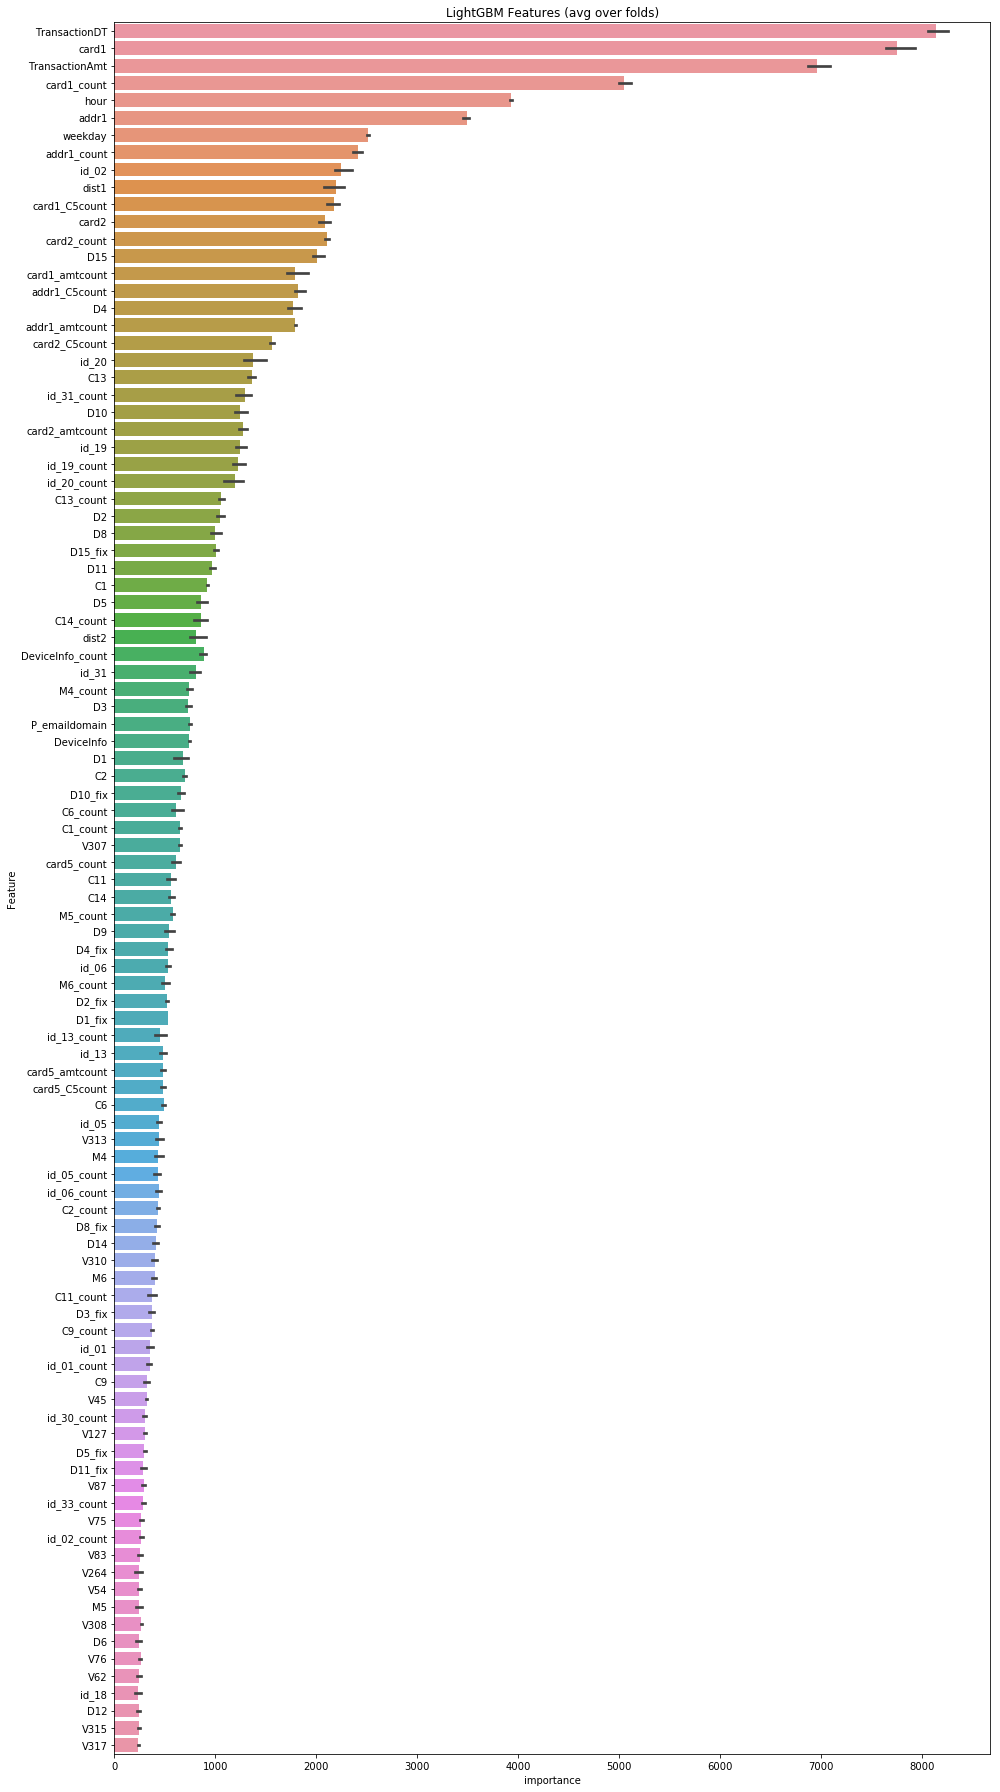

In [25]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [26]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if x not in col_del]

cate = [x for x in X_train.columns if (x == 'ProductCD' or x in ['card1','card2'] or x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-1), X_train[features].iloc[val_idx, :].fillna(-1)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=14,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-1), y_test),verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict_proba(X_test[features].fillna(-1),ntree_end = best_iter)[:,1]
    y_preds3+= temp / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, y_preds3))

['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6141151	test: 0.6153455	best: 0.6153455 (0)	total: 743ms	remaining: 8m 39s
30:	learn: 0.0900759	test: 0.1061623	best: 0.1061623 (30)	total: 22.5s	remaining: 8m 6s
60:	learn: 0.0656495	test: 0.0895418	best: 0.0895418 (60)	total: 44.8s	remaining: 7m 49s
90:	learn: 0.0568276	test: 0.0863144	best: 0.0863144 (90)	total: 1m 7s	remaining: 7m 29s
120:	learn: 0.0522701	test: 0.0852631	best: 0.0852631 (120)	total: 1m 29s	remaining: 7m 7s
150:	learn: 0.0489102	test: 0.0843435	best: 0.0843435 (150)	total: 1m 51s	remaining: 6m 45s
180:	learn: 0.0465889	test: 0.0837849	best: 0.0837849 (180)	total: 2m 13s	remaining: 6m 22s
210:	learn: 0.0452181	test: 0.0834429	best: 0.0834429 (210)	total: 2m 35s	remaining: 5m 59s
240:	learn: 0.0433399	test: 0.0831628	best: 0.0831628 (240)	total: 2m 56s	remaining: 5m 36s
270:	learn: 0.0420938	test: 0.0828359	best: 0.0828359 (270)	total: 3m 18s	re

In [27]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.4))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.4))

debug: 0.9316319098554862 0.08143807945604706
debug: 0.9243131389473382 0.09721213227907512
debug: 0.9212767495871879 0.08975283434758326
debug: 0.9357896416965188 0.08093605419783416
debug: 0.9393832393257803 0.07921023708203834
debug: 0.939489370227184 0.07920137506824708


In [28]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.4))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.4))

debug: 0.9316319098554862 0.08143807945604706
debug: 0.9243131389473382 0.09721213227907512
debug: 0.9212767495871879 0.08975283434758326
debug: 0.9357896416965188 0.08093605419783416
debug: 0.9393832393257803 0.07921023708203834
debug: 0.939489370227184 0.07920137506824708


In [29]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline9.csv')
else:
    sample_submission['isFraud'] = (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33
    sample_submission.to_csv('simple_ensemble9.csv')
